# Packages

In [56]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10

In [37]:
def flatten(list_of_lists):
    import collections
    
    for sublist in list_of_lists:
        if isinstance(sublist, collections.Iterable) and not isinstance(sublist, (str, bytes)):
            yield from flatten(sublist)
        else:
            yield sublist
            
            
def strf_date_if_not_na(x, strftime='%Y-%m'):
    if pd.isna(x):
        return np.nan
    else:
        return x.strftime('%Y-%m')

In [3]:
data_date = datetime.datetime(2020, 4, 11)
disease_startdate = datetime.datetime(2019, 11, 1)

# Subsetting and Pre-Organization

In [4]:
metadata = pd.read_csv('big-data/metadata_20-04-10.csv')
print('Number of CORD-19 rows: ' + str(len(metadata)))
metadata = metadata.drop_duplicates(subset=['cord_uid'], keep='first') # drop the very few duplicates
print('Number of CORD-19 rows: ' + str(len(metadata)))

Number of CORD-19 rows: 51078
Number of CORD-19 rows: 51045


In [5]:
metadata = metadata[pd.isnull(metadata['abstract']) == False].reset_index(drop=True)
print('Number of CORD-19 abstracts: ' + str(len(metadata)))
metadata = metadata[metadata['abstract'].str.lower().str.contains(
 "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome|sars-cov-2") | 
     metadata['abstract'].str.contains("MERS")
     ]
metadata = metadata.reset_index(drop=True)
print('Number of relevant CORD-19 rows: ' + str(len(metadata)))

Number of CORD-19 abstracts: 42331
Number of relevant CORD-19 rows: 11000


In [6]:
metadata['covid_or_not'] = metadata['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2')
print('Number of COVID-19 abstracts: ' + str(sum(metadata['covid_or_not'])))

Number of COVID-19 abstracts: 2481


# Author Analytics

In [7]:
metadata['authors'] = metadata['authors'].astype(str)
metadata['authors_split'] = metadata['authors'].apply(lambda x: x.split('; ')).tolist()

In [20]:
t = time.time()

article_authors = metadata[['cord_uid', 'authors_split']]
article_authors = article_authors.set_index(['cord_uid'])['authors_split'].apply(pd.Series)\
                                         .stack()\
                                         .reset_index(level=1, drop=True)
article_authors = article_authors.reset_index()
article_authors.columns = ['cord_uid', 'authors']

print(time.time() - t)
article_authors

30.867913961410522


,cord_uid,authors
0,fy4w7xz8,"Lin, Marie"
1,fy4w7xz8,"Tseng, Hsiang-Kuang"
2,fy4w7xz8,"Trejaut, Jean A"
3,fy4w7xz8,"Lee, Hui-Lin"
4,fy4w7xz8,"Loo, Jun-Hun"
...,...,...
77841,32bxx94u,"Lee, Changhee"
77842,4xhcamks,"Valkó, Anna"
77843,4xhcamks,"Bálint, Ádám"
77844,4xhcamks,"Bozsa, Ágnes"


In [21]:
article_authors = article_authors.merge(metadata[['cord_uid', 'publish_time']], how='left')
article_authors['converted_datetime'] = pd.to_datetime(article_authors['publish_time'], errors='coerce') # if format fails to parse, return NaT
article_authors = article_authors.sort_values('converted_datetime').reset_index(drop=True)
print(str(sum(pd.isna(article_authors['converted_datetime'] ))) + ' dates unavailable.')
print(str(sum(article_authors['converted_datetime'][
    pd.isna(article_authors['converted_datetime']) == False] > data_date)) + ' impossible dates.')
print('Examples of impossible dates: ')
article_authors[article_authors['converted_datetime'] > data_date]

7 dates unavailable.
710 impossible dates.
Examples of impossible dates: 


,cord_uid,authors,publish_time,converted_datetime
77129,1ei79lna,"Turner, Andrew J.",2020-04-30,2020-04-30
77130,vxywolgo,"Giombini, Emanuela",2020-04-30,2020-04-30
77131,vxywolgo,"Giansante, Filippo",2020-04-30,2020-04-30
77132,vxywolgo,"Giancola, Maria Letizia",2020-04-30,2020-04-30
77133,vxywolgo,"Garotto, Gabriele",2020-04-30,2020-04-30
...,...,...,...,...
77834,juxlh8xb,"Meng, Haotian",2020-12-31,2020-12-31
77835,juxlh8xb,"Huang, Jingze",2020-12-31,2020-12-31
77836,juxlh8xb,"Meng, Cui",2020-12-31,2020-12-31
77837,wyz5jyjh,"Qiu, Zhongmin",2020-12-31,2020-12-31


In [95]:
earliest_publication = article_authors[['authors', 'converted_datetime']].groupby('authors')\
            .min()[['converted_datetime']].reset_index()
earliest_publication.rename(columns={'converted_datetime' : 'earliest_date'}, inplace=True)
earliest_publication['earliest_month'] = earliest_publication['earliest_date'].map(lambda x: strf_date_if_not_na(x))
print(str(sum(earliest_publication['earliest_date'] > disease_startdate)) +
      ' authors had their first coronavirus publication after ' + str(disease_startdate))

author_publications_late = article_authors[article_authors['converted_datetime'] > disease_startdate]
print(str(len(np.unique(author_publications_late['authors']))) + ' unique authors published after ' + str(disease_startdate))

17769 authors had their first coronavirus publication after 2019-11-01 00:00:00
19251 unique authors published after 2019-11-01 00:00:00


In [40]:
article_authors['year_month'] = article_authors['converted_datetime'].map(lambda x: strf_date_if_not_na(x))

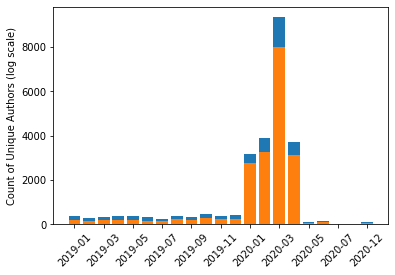

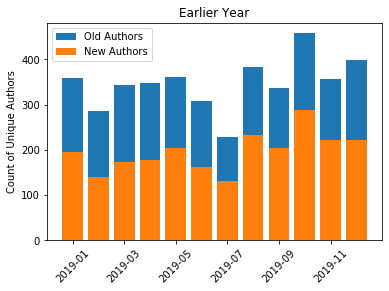

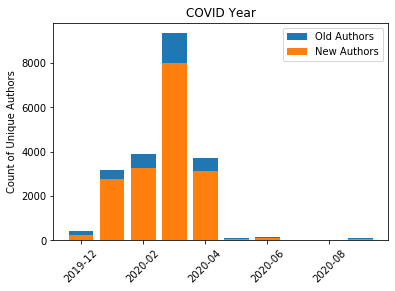

In [113]:
unique_authors_per_month = article_authors[['authors', 'year_month']].groupby('year_month').nunique()['authors']
unique_authors_per_month = unique_authors_per_month.reset_index()
new_authors_by_month = pd.DataFrame(earliest_publication[['authors', 'earliest_month']].\
                 groupby('earliest_month').count()['authors']).reset_index()
new_authors_by_month


unique_authors_per_month_subset = unique_authors_per_month[unique_authors_per_month['year_month'] >= '2019-01']
new_authors_by_month_subset = new_authors_by_month[new_authors_by_month['earliest_month'] >= '2019-01']
plt.bar(np.arange(len(unique_authors_per_month_subset)), unique_authors_per_month_subset['authors'])
plt.bar(np.arange(len(new_authors_by_month_subset)), new_authors_by_month_subset['authors'])
interval = 2
plt.xticks(np.arange(0, len(unique_authors_per_month_subset), interval),
           [a for e, a in enumerate(unique_authors_per_month_subset['year_month']) if e % interval == 0], 
           rotation=45)
# plt.yscale('log')
plt.ylabel('Count of Unique Authors (log scale)')
plt.show()


def plot_stuff(unique_authors_per_month_subset, new_authors_by_month_subset):
    plt.bar(np.arange(len(new_authors_by_month_subset)), unique_authors_per_month_subset['authors'], label='Old Authors')
    plt.bar(np.arange(len(new_authors_by_month_subset)), new_authors_by_month_subset['authors'], label='New Authors')
    interval = 2
    plt.xticks(np.arange(0, len(unique_authors_per_month_subset), interval),
               [a for e, a in enumerate(unique_authors_per_month_subset['year_month']) if e % interval == 0], 
               rotation=45)
    # plt.yscale('log')
    plt.ylabel('Count of Unique Authors')
    plt.legend()
    
unique_authors_per_month_subset = unique_authors_per_month[(unique_authors_per_month['year_month'] >= '2019-01') & 
                     (unique_authors_per_month['year_month'] <= '2019-12')]
new_authors_by_month_subset = new_authors_by_month_subset[(new_authors_by_month_subset['earliest_month'] >= '2019-01') & 
                     (new_authors_by_month_subset['earliest_month'] <= '2019-12')]
plot_stuff(unique_authors_per_month_subset, new_authors_by_month_subset)
plt.title('Earlier Year')
plt.show()


unique_authors_per_month_subset = unique_authors_per_month[(unique_authors_per_month['year_month'] >= '2019-12')]
new_authors_by_month_subset = new_authors_by_month[(new_authors_by_month['earliest_month'] >= '2019-12')]
plot_stuff(unique_authors_per_month_subset, new_authors_by_month_subset)
plt.title('COVID Year')
plt.show()

In [92]:
new_authors_by_month = pd.DataFrame(earliest_publication[['authors', 'earliest_date']].\
                 groupby('earliest_date').nunique()['authors']).reset_index()
new_authors_by_month_subset = new_authors_by_month[new_authors_by_month['earliest_date'] >= '2019-01-01']
len(new_authors_by_month_subset)

320

Relevant information:
* Authors
* Dates
* 50k authors to check against